Import all libraries and read in dataset

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from random import randint
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

df = pd.read_csv(
    "../Dataset/adult.data", 
    names=[
        'age',
        'workclass', 
        'fnlwgt',
        'education',
        'education-num',
        'marital_status',
        'occupation',
        'relationship',
        'race',
        'sex',
        'capital-gain',
        'capital-loss',
        'hours-per-week',
        'native-country',
        'income'],
    index_col=False
    )
df


,age,workclass,fnlwgt,education,education-num,marital_status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,-1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,-1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,-1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,-1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,-1
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,-1
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,-1


Data Pre-processing

In [32]:
# Normalise all continuous data between 0 and 1
for x in ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']:
    df[x] = (df[x] - df[x].min()) / (df[x].max() - df[x].min())

# Binarise categorical data
df = pd.get_dummies(df)

# Split dataset into a training and validation set
train,validate = train_test_split(df, test_size=0.6)
train,validate

(       age    fnlwgt  education-num  capital-gain  capital-loss  \
 509     39  0.054136       0.533333           0.0      0.000000   
 2005    27  0.169920       0.533333           0.0      0.000000   
 15933   65  0.117301       0.333333           0.0      0.000000   
 32319   54  0.140892       0.533333           0.0      0.000000   
 5244    58  0.088220       0.533333           0.0      0.000000   
 ...    ...       ...            ...           ...           ...   
 24964   44  0.064121       0.533333           0.0      0.000000   
 299     38  0.106752       0.533333           0.0      0.000000   
 1262    69  0.124621       0.666667           0.0      0.000000   
 2904    31  0.031783       0.600000           0.0      0.383838   
 17685   46  0.069189       0.866667           0.0      0.436639   
 
        hours-per-week  income  workclass_ ?  workclass_ Federal-gov  \
 509          0.397959      -1             0                       0   
 2005         0.295918      -1        

In [33]:
# Split the train and test datasets into attribute and tags
train_x,train_y = train.drop(columns='income').to_numpy(), train['income'].to_numpy()
validate_x,validate_y = validate.drop(columns='income').to_numpy(), validate['income'].to_numpy()

Implementing the prediction functions

In [34]:
def predict_(model, data,bias):
    results = 0
    # Iterate through each parameter of the model
    for i in range(len(data)):
        
        results += model[i] * data[i]
    
    return results+bias

# Give the prediction in a binary (+ or -) result rather 
# than the continuous prediction of the predict_ function
def predict(model,data,bias):
    return np.sign(predict_(model,data,bias))

Implementing the scoring and error functions of the model

In [40]:
def score(model,X, bias):
    return X.dot(model) + bias

def error(model, X, y, bias):
    pred = predict(model,X, bias)
    
    if pred == y:
        return 0
    else:
        return np.abs(score(model, X, bias))
    
def total_error(model, X, y, bias):
    total_error=0
    for i in range(len(X)):
        
        total_error+=error(model, X[i], y[i], bias)
    return total_error
        

Implementing the training Algorithm

In [59]:
# This is one iteration/epoch of the model

def iterate_model(model, X, y, bias, learing_rate = 0.01):
    pred = predict(model, X, bias)
    for i in range(len(model)):
        model[i] += (y-pred)*X[i]*learing_rate
        bias += (y - pred)*learing_rate
    return model,bias

def train_model(X, y, learning_rate=0.01, epochs = None, min_epoch=10):
    if epochs ==None: epochs= len(X)
    bias = 0.0
    model = np.full((len(X[0])),1, dtype=float)
    errors = []

    for i in tqdm(range(epochs)):
        errors.append(total_error(model,X,y, bias))

        # try:
        #     if errors[i] <= errors[i-5] and len(errors)>=min_epoch: break
        # except:
        #     pass
        j = randint(0, len(X)-1)
        model,bias = iterate_model(model, X[j], y[j], bias, learing_rate=learning_rate)
    return model, errors,bias


In [61]:
model,errors,bias = train_model(train_x, train_y, epochs=150)
model, errors, bias

(array([-0.46      ,  0.99236113,  0.96      ,  1.02614966,  0.99071166,
         1.01285714,  0.98      ,  1.        ,  1.        ,  1.        ,
         0.84      ,  1.        ,  1.06      ,  0.98      ,  1.        ,
         1.        ,  0.98      ,  1.        ,  1.        ,  1.        ,
         1.02      ,  1.        ,  0.98      ,  0.96      ,  1.        ,
         1.        ,  0.78      ,  1.12      ,  1.        ,  1.02      ,
         1.        ,  1.        ,  1.        ,  1.22      ,  0.96      ,
         0.74      ,  0.98      ,  0.96      ,  0.98      ,  0.9       ,
         1.        ,  1.08      ,  1.08      ,  0.98      ,  1.        ,
         1.        ,  0.92      ,  1.        ,  1.08      ,  0.98      ,
         1.        ,  0.92      ,  0.94      ,  1.2       ,  0.86      ,
         0.96      ,  0.9       ,  0.92      ,  1.02      ,  0.98      ,
         0.98      ,  0.86      ,  1.        ,  1.04      ,  0.74      ,
         1.12      ,  1.        ,  1.        ,  1.0

In [44]:
def validation_error(X,y, model, bias):
    sum_positive = 0
    for i in range(len(y)):
        if predict(model, X[i], bias)==y[i]:
            sum_positive +=1
       
    return sum_positive/len(X)

In [62]:
validation_error(validate_x,validate_y, model, bias)

0.7585606797358857

Graphing Error over time

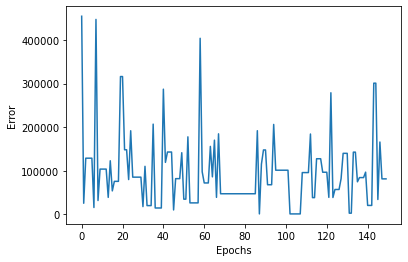

In [63]:
plt.plot(errors)
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.show()